In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline

import sys
sys.version

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


'3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]'

- 总结利用随机森林回测的具体步骤，找到进一步的研究切入点：

1）导入单品种期货数据


2）建立特征因子（labels）


3）建立机器学习目标（targets）


4）将特征因子和学习目标合并为master_dataframe

5）选取训练集+测试的时间区间；再选取验证集的时间区间

6）以数量大的target类别为基准，针对训练集，利用resample平衡target不同类别(比如0和1)的数据数量，再将labels列数据和targets列数据分开，分别为X和y

7）将X数据标准化（normalize）：平均值在0附近，方差为1

8）用train_test_split函数分割数据，得到X的训练集，X的测试集，y的训练集，y的测试集，并定义test_size（研究问题1：搞明白X_train, X_test, y_train, y_test = 

train_test_split(X, y, test_size=1/6)的运作机制）https://blog.csdn.net/kyriehe/article/details/77507473 

9）选择模型，训练并测试，并评估模型（研究问题2：model.fit(X_train, y_train)和scores(model, X_test, y_test)的运作机制）

10）先用模型默认参数训练、测试训练测试集，抛出结果（a. 预测准确率、b. f1分数、c. ROC Curve Score分布面积）

11）选择需要优化的参数字典列表，定义为grid_data，并根据a. 预测准确率、b. f1分数和c. ROC Curve Score分布面积，求出最优参数组

12）将参数重新带进模型中，打印出整体训练+测试集中，最优参数模型得出的预测准确率、F1分数以及ROC Curve Score分布面积（通常会很高，80%-90%以上，这个部分的回测曲线会非常好）

13）将此最优参数组带入模型，打印出验证集的结果（通常降低很低）（这个部分的曲线会接近实盘曲线）（研究问题3：训练、测试、验证集之间的关系和运作机制）

14）画出两种结果的回测图


# Breakdown the function get_data(symbol)

## Step 1 - Create features

In [2]:
location =  "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_11_minute_data/15_min_data/"
jd = "T9000_15mins.csv"

df = pd.read_csv(location+jd, engine="python", header=None)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']

In [3]:
df.head()

,date,open,high,low,close,volume,open_interests
0,2015/03/20 09:15,96.900,97.965,96.900,97.010,1018,402
1,2015/03/20 09:30,97.015,97.050,96.545,96.715,982,646
2,2015/03/20 09:45,96.710,96.800,96.650,96.720,278,654
3,2015/03/20 10:00,96.720,96.760,96.705,96.760,48,639
4,2015/03/20 10:15,96.765,96.820,96.750,96.775,116,647


In [4]:
def get_indicators(data, n, indicator):
    
    ###### Step 1: Calculate necessary time series ######
    up, dw = data['close'].diff(), -data['close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    # default set to be 12-period ema as the fast line, 26 as the slow line:
    macd = data['close'].ewm(12).mean() - data['close'].ewm(26).mean()
    # default set to be 9-period ema of the macd
    macd_signal = macd.ewm(9).mean()
    
    ###### Step 2: Create dataframe and fill with technical indicators: ######
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'momentum', 'rsi', 'macd'])
#     indicators['date'] = data['date']
    indicators['sma'] = data['close'].rolling(n).mean()
    indicators['ema'] = data['close'].ewm(n).mean()
    indicators['momentum'] = data['close'] - data['close'].shift(n)
    indicators['rsi'] = 100 - 100 / (1 + up.rolling(n).mean() / dw.rolling(n).mean())
    indicators['macd'] = macd - macd_signal
    indicators.index = data['date']
    
    return indicators[[indicator]]

def get_data(df, n):
    # technical indicators
    sma = get_indicators(df, n, 'sma')
    ema = get_indicators(df, n, 'ema')
    momentum = get_indicators(df, n, 'momentum')
    rsi = get_indicators(df, n, 'rsi')
    macd = get_indicators(df, n, 'macd')
    tech_ind = pd.concat([sma, ema, momentum, rsi, macd], axis = 1)
    df.index = df['date']
    close = df['close']
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'
    master_df = pd.concat([tech_ind, close, target], axis=1)
    return master_df


def rebalance(unbalanced_data):
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    # Separate majority and minority classes

    if data.target.value_counts()[0]>data.target.value_counts()[1]:
        print ("majority:0, length: {}; minority:1, length: {}".format(data.target.value_counts()[0],data.target.value_counts()[1]))
        data_minority = unbalanced_data[unbalanced_data.target==1] 
        data_majority = unbalanced_data[unbalanced_data.target==0] 
    else:
        print ("majority:1, length: {}; minority:0, length: {}".format(data.target.value_counts()[1],data.target.value_counts()[0]))
        data_minority = unbalanced_data[unbalanced_data.target==0] 
        data_majority = unbalanced_data[unbalanced_data.target==1] 

    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)

    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    data_upsampled.sort_index(inplace=True)

    # Display new class counts
    data_upsampled.target.value_counts()

    return data_upsampled


def normalize(x):
    scaler = StandardScaler()
    # 公式为：(X-mean)/std  计算时对每个属性/每列分别进行。
    # 将数据按期属性（按列进行）减去其均值，并除以其方差。得到的结果是，对于每个属性/每列来说所有数据都聚集在0附近，方差为1。
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    return x_norm


def scores(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))

## Create master dataframes

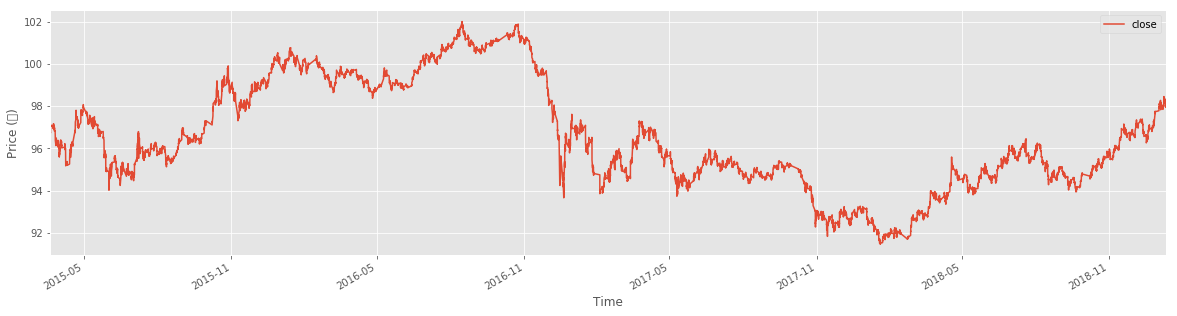

In [5]:
# Part 1:

master_df = get_data(df, 10)
data = master_df.copy()
data.index = pd.to_datetime(data.index)
data.tail(10)
data.describe()
ax = data[['close']].plot(figsize=(20, 5))
ax.set_ylabel("Price (￥)")
ax.set_xlabel("Time")
plt.show()

In [6]:
# Part 2:

data_train = data['2011-01-01':'2017-01-01']
# Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
data_train = rebalance(data_train).dropna()
# y as the label target 
y = data_train.target
# X as the dataframe with their values to be normalized
X = data_train.drop('target', axis=1)
X = normalize(X)

majority:0, length: 8754; minority:1, length: 8058


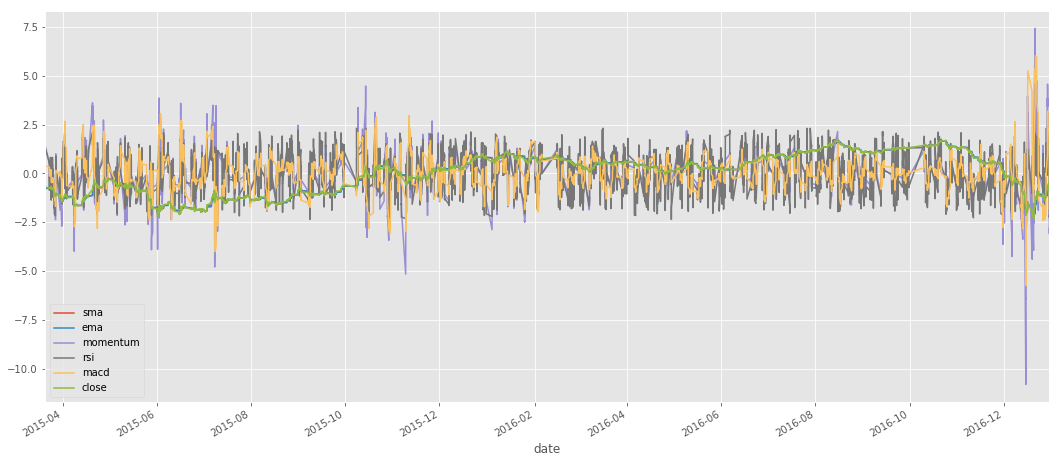

In [7]:
# Plotted chart based on normalized dataframe values. 
X.head(100000).dropna().plot(figsize = (18, 8))

In [8]:
data_val = data['2017-01-01':]
data_val.dropna(inplace=True)
# y_val as the label target in the validation period
y_val = data_val.target
# X_val as the dataframe with their values to be normalized in the validation period
X_val = data_val.drop('target', axis=1)
# normalize
X_val = normalize(X_val)

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
# Part 3"
# Machine Learning

# Train test split
import sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

看一下四个数据集长什么样子：

In [10]:
print ("X_train length: ", len(X_train))
print ("X_test length: ", len(X_test))
print ("y_train length:", len(y_train))
print ("y_test length:", len(y_test))

X_train length:  6837
X_test length:  1368
y_train length: 6837
y_test length: 1368


In [11]:
# Specify the parameters of the model
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)
model.fit(X_train, y_train)
scores(model, X_test, y_test)

Accuracy Score: 70.32 %
F1 Score: 0.7104
Area Under ROC Curve Score: 0.7034


In [12]:
# Take a look at the optimal parameters
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [13]:
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_pred)
print("Accuracy Score: {0:0.2f} %".format(acc * 100))
print("F1 Score: {0:0.4f}".format(f1))
print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
print ("----------------------------------------------------")
print ("model", model)

Accuracy Score: 95.05 %
F1 Score: 0.9508
Area Under ROC Curve Score: 0.9505
----------------------------------------------------
model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)


In [14]:
# Validation data
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
print("Accuracy Score: {0:0.2f} %".format(acc * 100))
print("F1 Score: {0:0.4f}".format(f1))
print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
print ("----------------------------------------------------")
print ("model", model)

Accuracy Score: 50.92 %
F1 Score: 0.3874
Area Under ROC Curve Score: 0.5016
----------------------------------------------------
model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)


In [15]:
len(y_val)

8910

In [16]:
len(y_pred)

8910

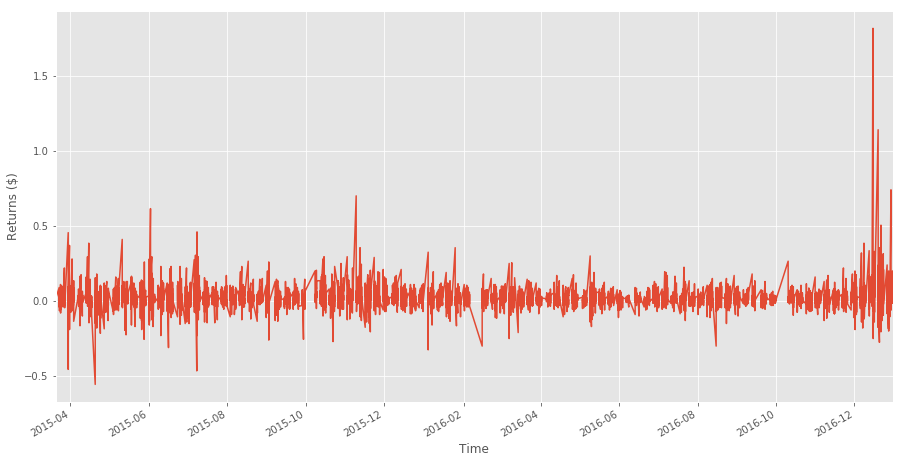

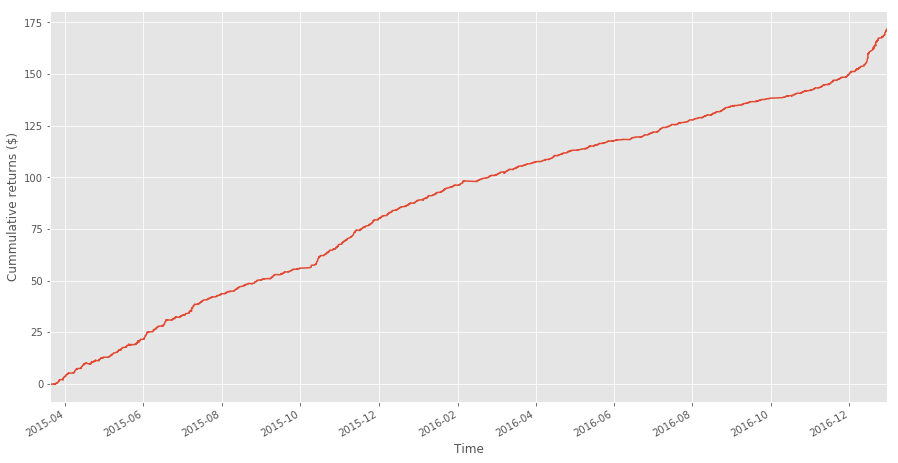

In [17]:
# See backtest of trained overfitted results:

# Trading system
# for i in range(1):
#     print ("======================================================================")
#     print ("Testing Model{}...".format(i+1))
rf_model = model
y_pred = rf_model.predict(X)
mask = y_pred.copy()
np.place(mask, y_pred==0, -1)
mask = np.roll(mask, 1)
data_returns = data['close'].diff()
data_returns = data_returns[X.index]
model_returns = mask * data_returns
model_cum = model_returns.cumsum()
equity = model_returns.sum()
start_close = data["close"][X.index[0]]
performance = equity / start_close * 100
ax = model_returns.plot(figsize=(15, 8))
ax.set_ylabel("Returns ($)")
ax.set_xlabel("Time")
plt.show()
ax = model_cum.plot(figsize=(15, 8))
ax.set_ylabel("Cummulative returns ($)")
ax.set_xlabel("Time")
plt.show()

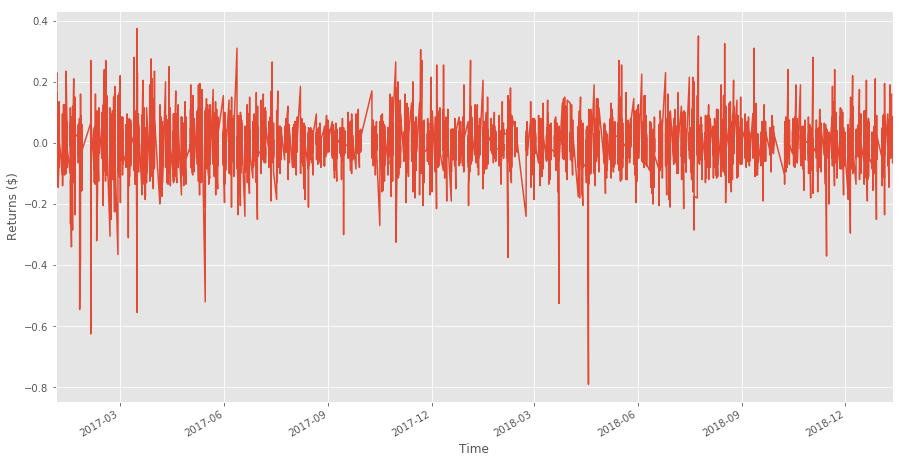

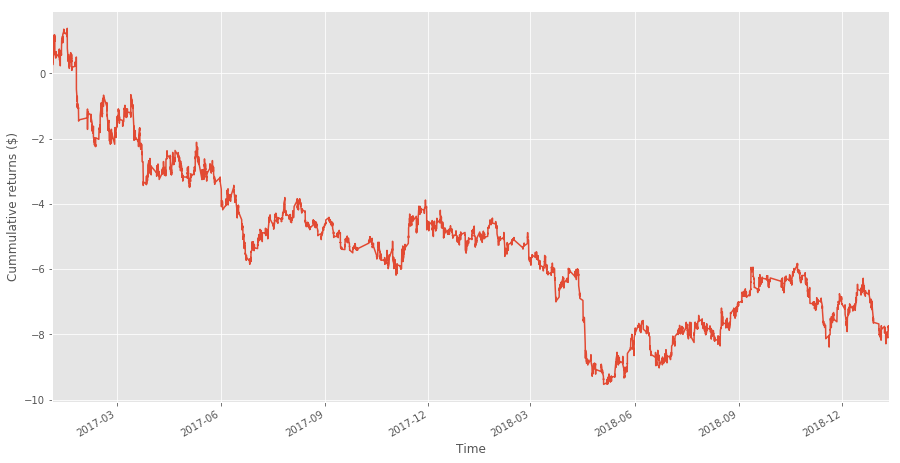

In [18]:
# Trading system: testing real performance:

rf_model = model
y_pred = rf_model.predict(X_val)
mask = y_pred.copy()
np.place(mask, y_pred==0, -1)
mask = np.roll(mask, 1)
data_returns = data['close'].diff()
data_returns = data_returns[X_val.index]
model_returns = mask * data_returns
model_cum = model_returns.cumsum()
equity = model_returns.sum()
start_close = data["close"][X_val.index[0]]
performance = equity / start_close * 100
ax = model_returns.plot(figsize=(15, 8))
ax.set_ylabel("Returns ($)")
ax.set_xlabel("Time")
plt.show()
ax = model_cum.plot(figsize=(15, 8))
ax.set_ylabel("Cummulative returns ($)")
ax.set_xlabel("Time")
plt.show()

In [19]:
X_val.head(2)

,sma,ema,momentum,rsi,macd,close
date,,,,,,
2017-01-03 09:15:00,1.615787,1.659769,-3.336847,-2.323671,-2.331075,1.511692
2017-01-03 09:30:00,1.589878,1.648403,-2.094675,-2.029970,-2.517835,1.525670


In [20]:
master_pred_df = X_val.copy()
# y_pred is the signal predicting next day's increase or decrease in the asset price
master_pred_df['y_pred'] = y_pred
# y_val is the real actual increase or decrease in the asset price
master_pred_df['y_val'] = y_val

In [21]:
master_pred_df.head()

,sma,ema,momentum,rsi,macd,close,y_pred,y_val
date,,,,,,,,
2017-01-03 09:15:00,1.615787,1.659769,-3.336847,-2.323671,-2.331075,1.511692,1,1
2017-01-03 09:30:00,1.589878,1.648403,-2.094675,-2.029970,-2.517835,1.525670,0,0
2017-01-03 09:45:00,1.567470,1.637432,-1.812363,-1.970344,-2.666870,1.518681,1,1
2017-01-03 10:00:00,1.556266,1.635124,-0.908965,-0.835902,-2.622114,1.602549,0,0
2017-01-03 10:15:00,1.554515,1.632707,-0.146723,-0.195886,-2.576811,1.599055,0,0


In [22]:
mask_ = y_pred.copy()

In [23]:
mask_

array([1, 0, 1, ..., 0, 0, 0])

In [24]:
# replace mask_'s 0 with -1
np.place(mask_, mask_==0, -1)

In [25]:
mask__ = np.roll(mask_, 1)

In [26]:
data_returns_ = data['close'].diff()

In [27]:
# take the sample based on X_val's time index: data_returns_ starts from 2015-3-20, data_returns__ starts from 2017-1-3:
data_returns__ = data_returns_[X_val.index]

In [28]:
len(mask)

8910

In [29]:
master_pred_df['mask'] = mask
master_pred_df['mask_'] = mask_
master_pred_df['mask__'] = mask__
master_pred_df['data_returns__'] = data_returns__
model_returns_ = mask__ * data_returns__
master_pred_df['model_returns_'] = model_returns_
del master_pred_df['mask_']

In [30]:
# here mask = mask__
# mask__ is the predicting signals, and data_returns__ is the actual rise or drop in price change
master_pred_df

,sma,ema,momentum,rsi,macd,close,y_pred,y_val,mask,mask__,data_returns__,model_returns_
date,,,,,,,,,,,,
2017-01-03 09:15:00,1.615787,1.659769,-3.336847,-2.323671,-2.331075,1.511692,1,1,-1,-1,-0.025,0.025
2017-01-03 09:30:00,1.589878,1.648403,-2.094675,-2.029970,-2.517835,1.525670,0,0,1,1,0.020,0.020
2017-01-03 09:45:00,1.567470,1.637432,-1.812363,-1.970344,-2.666870,1.518681,1,1,-1,-1,-0.010,0.010
2017-01-03 10:00:00,1.556266,1.635124,-0.908965,-0.835902,-2.622114,1.602549,0,0,1,1,0.120,0.120
2017-01-03 10:15:00,1.554515,1.632707,-0.146723,-0.195886,-2.576811,1.599055,0,0,-1,-1,-0.005,0.005
2017-01-03 10:30:00,1.553815,1.629870,-0.062029,-0.093400,-2.537140,1.592066,0,0,-1,-1,-0.010,0.010
2017-01-03 10:45:00,1.546112,1.620264,-0.626653,-0.644652,-2.625489,1.515187,0,0,-1,-1,-0.110,0.110
2017-01-03 11:00:00,1.542961,1.608337,-0.259648,-0.319781,-2.740077,1.480242,0,0,-1,-1,-0.050,0.050
2017-01-03 11:15:00,1.531757,1.591106,-0.908965,-0.889120,-2.935153,1.410352,0,1,-1,-1,-0.100,0.100


In [32]:
# 将信号数据集和原来的OHLC数据集合并
master_pred_df.head()

,sma,ema,momentum,rsi,macd,close,y_pred,y_val,mask,mask__,data_returns__,model_returns_
date,,,,,,,,,,,,
2017-01-03 09:15:00,1.615787,1.659769,-3.336847,-2.323671,-2.331075,1.511692,1,1,-1,-1,-0.025,0.025
2017-01-03 09:30:00,1.589878,1.648403,-2.094675,-2.029970,-2.517835,1.525670,0,0,1,1,0.020,0.020
2017-01-03 09:45:00,1.567470,1.637432,-1.812363,-1.970344,-2.666870,1.518681,1,1,-1,-1,-0.010,0.010
2017-01-03 10:00:00,1.556266,1.635124,-0.908965,-0.835902,-2.622114,1.602549,0,0,1,1,0.120,0.120
2017-01-03 10:15:00,1.554515,1.632707,-0.146723,-0.195886,-2.576811,1.599055,0,0,-1,-1,-0.005,0.005


In [67]:
df_dt = df.copy()
del df_dt['date']
df_dt.reset_index(inplace= True)
df_dt['date'] = pd.to_datetime(df_dt['date'])
# df_dt.index = df_dt['date']
# del df_dt['date']

In [68]:
df_dt.head(3)

,date,open,high,low,close,volume,open_interests
0,2015-03-20 09:15:00,96.900,97.965,96.900,97.010,1018,402
1,2015-03-20 09:30:00,97.015,97.050,96.545,96.715,982,646
2,2015-03-20 09:45:00,96.710,96.800,96.650,96.720,278,654


In [78]:
master_pred_df_dt = master_pred_df.copy()
master_pred_df_dt.reset_index(inplace = True)

In [79]:
master_pred_df_dt.head(3)

,date,sma,ema,momentum,rsi,macd,close,y_pred,y_val,mask,mask__,data_returns__,model_returns_
0,2017-01-03 09:15:00,1.615787,1.659769,-3.336847,-2.323671,-2.331075,1.511692,1,1,-1,-1,-0.025,0.025
1,2017-01-03 09:30:00,1.589878,1.648403,-2.094675,-2.029970,-2.517835,1.525670,0,0,1,1,0.020,0.020
2,2017-01-03 09:45:00,1.567470,1.637432,-1.812363,-1.970344,-2.666870,1.518681,1,1,-1,-1,-0.010,0.010


In [80]:
master_pred_df_dt = master_pred_df_dt[['date', 'mask']]
merged = df_dt[['date', 'open', 'high', 'low', 'close']].merge(master_pred_df_dt, on = 'date')
merged.columns = ['date', 'open', 'high', 'low', 'close', 'signals']
merged.to_csv(location+'T9000_RF_signals.csv', index = False)

In [90]:
merged.to_csv(location+'T9000_RF_signals_header_False.csv', index = False, header=False)

In [91]:
RandomForestClassifier?